# This workbook takes data in .csv format for OMNI and an observatory and turns the data into a machine learning ready dataset combining the two .csv files.

The first thing to note is that extraction of events is optional, as is demonstrated clearly above that section before the data is placed into a new csv, netcdf or hdf format.

In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import tqdm

import utils

In [2]:
###Step 1: Get current directory and set PATH variable to where data has been saved.

import os

# Get the current working directory
current_path = os.getcwd()

# Print the current working directory
print("Current working directory:", current_path)

#define path to data folder where data will be placed. Print current path if you don't know what it is!
PATH = '/mnt/c/users/s1725621/Documents/PhDCode/Git/CrossformerTimeSeries/Data/'

Current working directory: /mnt/c/users/s1725621/Documents/PhDCode/Git/CrossformerTimeSeries/Data


In [4]:
###Step 2: Import dataset from csv
observatory='LER'
obs=pd.read_csv(PATH + observatory +'19982020.csv',index_col='Timestamp')###Observatory Dataset downloaded
obs=obs.to_xarray() #Into xarray

OMNIset=pd.read_csv(PATH + 'OMNI19982020.csv',index_col='Timestamp')###OMNI Dataset downloaded
OMNIset.index=pd.to_datetime(OMNIset.index)
OMNIset.index= pd.to_datetime(OMNIset.index, unit='ns')
OMNIset.index = OMNIset.index.strftime('%Y-%m-%d %H:%M:%S')
OMNIset=OMNIset.to_xarray() #Into xarray

print(obs)
print(OMNIset)

<xarray.Dataset> Size: 555MB
Dimensions:    (Timestamp: 11568960)
Coordinates:
  * Timestamp  (Timestamp) object 93MB '1998-01-01 00:00:00' ... '2019-12-31 ...
Data variables:
    B_N        (Timestamp) float64 93MB 1.196 0.8947 0.6947 ... 3.04 3.04 3.241
    B_E        (Timestamp) float64 93MB -31.69 -31.72 -31.74 ... 23.17 23.37
    B_C        (Timestamp) float64 93MB 13.02 13.32 13.32 ... -28.36 -28.46
    B_H        (Timestamp) float64 93MB -6.822 -7.124 -7.325 ... 9.81 10.01
    dBdt       (Timestamp) float64 93MB nan -0.3024 -0.201 ... 0.001354 0.203
<xarray.Dataset> Size: 871MB
Dimensions:         (Timestamp: 12097440)
Coordinates:
  * Timestamp       (Timestamp) object 97MB '1998-01-01 00:00:00' ... '2020-1...
Data variables:
    BY_GSM          (Timestamp) float64 97MB 5.41 5.51 4.04 ... -1.41 0.09 1.15
    BZ_GSM          (Timestamp) float64 97MB 2.31 1.92 1.59 ... 1.05 0.98 0.38
    flow_speed      (Timestamp) float64 97MB 357.6 357.6 351.6 ... 358.8 358.5
    proton_density

# Save all data to machine learning ready format.

In [22]:
###Merge dataset

OMNIset=OMNIset.sel(Timestamp=obs.Timestamp)

events_tot=xr.merge([obs,OMNIset])

In [23]:
print(events_tot)

<xarray.Dataset> Size: 1GB
Dimensions:         (Timestamp: 11568960)
Coordinates:
  * Timestamp       (Timestamp) object 93MB '1998-01-01 00:00:00' ... '2019-1...
Data variables: (12/13)
    B_N             (Timestamp) float64 93MB 1.196 0.8947 0.6947 ... 3.04 3.241
    B_E             (Timestamp) float64 93MB -31.69 -31.72 ... 23.17 23.37
    B_C             (Timestamp) float64 93MB 13.02 13.32 13.32 ... -28.36 -28.46
    B_H             (Timestamp) float64 93MB -6.822 -7.124 -7.325 ... 9.81 10.01
    dBdt            (Timestamp) float64 93MB nan -0.3024 ... 0.001354 0.203
    BY_GSM          (Timestamp) float64 93MB 5.41 5.51 4.04 ... 2.08 3.37 3.31
    ...              ...
    flow_speed      (Timestamp) float64 93MB 357.6 357.6 351.6 ... 294.7 nan
    proton_density  (Timestamp) float64 93MB 6.85 6.85 4.74 ... 5.7 5.19 nan
    T               (Timestamp) float64 93MB 1.007e+05 1.007e+05 ... 2.4e+04 nan
    Pressure        (Timestamp) float64 93MB 1.75 1.75 1.17 1.6 ... 1.01 0.9 nan


In [24]:
###Step 5: save OMNI data.

###Save to netcdf file
events_tot.to_netcdf(path = PATH+'OMNImerge'+observatory+'19982020.nc')

###Save to csv file
# Convert xarray Dataset to pandas DataFrame
OMNIsetf = events_tot.to_dataframe()

# Save the DataFrame to a CSV file
OMNIsetf.to_csv(PATH+'OMNImerge'+observatory+'19982020.csv',index=True)

KeyboardInterrupt: 

# Save only events above a certain threshold to machine learning ready format.

In [5]:
##Set dBdt threshold beyond which an "event" has been initiated. Will vary based on location.
exceed=75
print(f"Finding events with dBdt exceendance {exceed} nT/min")

###Get datetime column in correct format.
storm_events_tot=events_tot.to_pandas()
storm_events_tot.index=pd.to_datetime(storm_events_tot.index)
storm_events_tot=storm_events_tot.to_xarray()

##Find events.
storm_events_tot=utils.find_events(storm_events_tot, exceed, interval=np.timedelta64(6,'h'))

print('Found',len(storm_events_tot.B_H)//(60*24),f'days in range')

print(storm_events_tot)

Finding events with dBdt exceendance 75 nT/min


NameError: name 'events_tot' is not defined

In [ ]:
###Step 5: save OMNI data.

###Save to netcdf file
storm_events_tot.to_netcdf(path = PATH+'OMNIstorms'+observatory+'19982020and'+str(exceed)+'nTmin.nc')

###Save to csv file
# Convert xarray Dataset to pandas DataFrame
OMNIsetf = storm_events_tot.to_dataframe()

# Save the DataFrame to a CSV file
OMNIsetf.to_csv(PATH+'OMNIstorms'+observatory+'19982020and'+str(exceed)+'nTmin.csv',index=True)

# Code for adding k, positional encoding and other parameters.

In [6]:
#k.
k=[]
t=0
for i in range(len(obs.Timestamp)):
    k.append(t)
    t+=1

In [7]:
print(len(obs.Timestamp))

11568960


In [8]:
#additional parameters: MLT, time of year, smoothed solar number from source.

#Smoothed solar number- monthly. From SILSO.
import pandas as pd
sunspotnum=pd.read_csv('SN_m_tot_V2.0 (1).csv',header=None,sep=';')

sunspotnum.head()

sunspotnum['date'] = pd.to_datetime(dict(year=sunspotnum[0], month=sunspotnum[1], day=1))

print(sunspotnum.head())

      0  1         2      3    4  5  6       date
0  1749  1  1749.042   96.7 -1.0 -1  1 1749-01-01
1  1749  2  1749.123  104.3 -1.0 -1  1 1749-02-01
2  1749  3  1749.204  116.7 -1.0 -1  1 1749-03-01
3  1749  4  1749.288   92.8 -1.0 -1  1 1749-04-01
4  1749  5  1749.371  141.7 -1.0 -1  1 1749-05-01


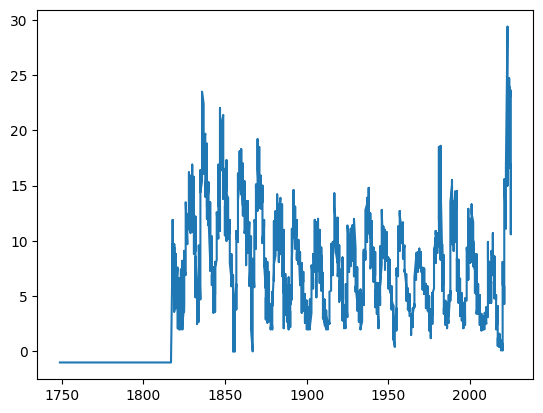

In [9]:
timearray=np.array(obs.Timestamp)

plt.plot(sunspotnum[0],sunspotnum[4])


               0  1         2      3    4  5  6
date                                           
1749-01-01  1749  1  1749.042   96.7 -1.0 -1  1
1749-02-01  1749  2  1749.123  104.3 -1.0 -1  1
1749-03-01  1749  3  1749.204  116.7 -1.0 -1  1
1749-04-01  1749  4  1749.288   92.8 -1.0 -1  1
1749-05-01  1749  5  1749.371  141.7 -1.0 -1  1


/tmp/ipykernel_21211/4235819718.py:9: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  sunspotnum = sunspotnum.resample('T').interpolate('linear')


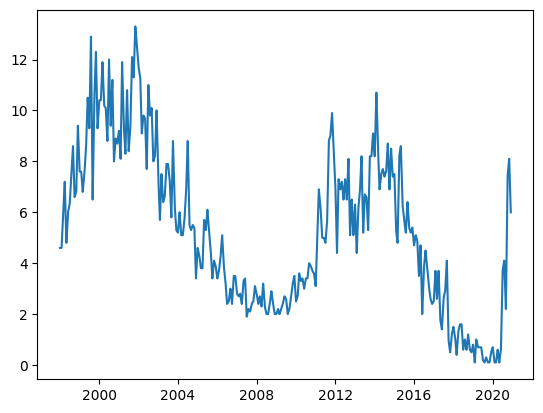

In [10]:
import matplotlib.pyplot as plt

sunspotnum.set_index('date', inplace=True)

print(sunspotnum.head())

sunspotnum = sunspotnum.loc['1998':'2020']

sunspotnum = sunspotnum.resample('T').interpolate('linear')
####NOTE: WE DO INTERPOLATION HERE. THIS IS PROBABLY THE CORRECT THING TO DO BUT IT NEEDS TO BE EXPLAINED WELL IN THE WRITE UP.

plt.plot(sunspotnum[4])

In [11]:
sunspotnum.loc[timearray]

sunspotnum=sunspotnum.loc[obs.Timestamp]

print(sunspotnum.columns)


Index([0, 1, 2, 3, 4, 5, 6], dtype='object')


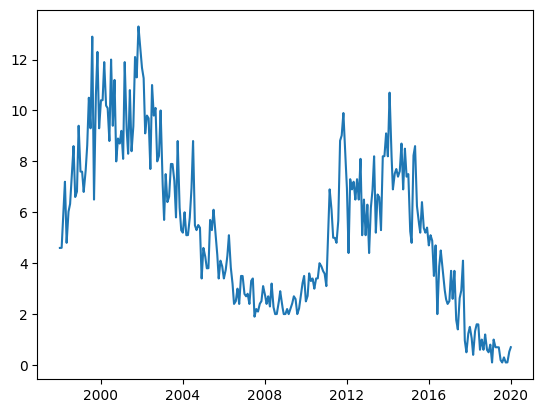

In [12]:
plt.plot(sunspotnum[4])


In [13]:
##Time of year
timearray = pd.to_datetime(obs['Timestamp'])

print(timearray[0])

# Extract years
years = timearray.year

# Convert years into datetime (as Jan 1st)
year_start = pd.to_datetime(years.astype(str) + '-01-01')

print(years[0])

delta = (timearray - year_start)

delta= delta.total_seconds()

1998-01-01 00:00:00
1998


In [14]:
print(delta[0:10])

Index([0.0, 60.0, 120.0, 180.0, 240.0, 300.0, 360.0, 420.0, 480.0, 540.0], dtype='float64')


In [15]:
from datetime import datetime

def percentage_through_year(datetimes):
    percentages = []
    for dt in datetimes:
        start_of_year = datetime(dt.year, 1, 1)
        start_of_next_year = datetime(dt.year + 1, 1, 1)
        year_duration = (start_of_next_year - start_of_year).total_seconds()
        elapsed = (dt - start_of_year).total_seconds()
        percentage = (elapsed / year_duration) * 100
        percentages.append(percentage)
    return percentages

In [16]:
percentages = percentage_through_year(timearray)


In [17]:
print(percentages[0:10])

[0.0, 0.0001902587519025875, 0.000380517503805175, 0.0005707762557077625, 0.00076103500761035, 0.0009512937595129377, 0.001141552511415525, 0.0013318112633181126, 0.0015220700152207, 0.0017123287671232876]


In [19]:
##MAGNETIC LOCAL TIME##

###This is not magnetic local time. This is just plain ol local time. How to get magnetic local time?
##!pip install apexpy
##!conda install -c conda-forge apexpy
##!pip install --upgrade chaosmagpy
import chaosmagpy.coordinate_utils
print(dir(chaosmagpy.coordinate_utils))

def datetime_to_mjd(dtimes):
    # Convert pandas or numpy datetime64 to JD then to MJD
    # Reference: JD = 2440587.5 + unix_time_in_days
    # Unix epoch: 1970-01-01 00:00:00 UTC
    unix_epoch = np.datetime64('1970-01-01T00:00:00Z')
    dtimes = np.array(dtimes, dtype='datetime64[ns]')
    unix_seconds = (dtimes - unix_epoch) / np.timedelta64(1, 's')
    jd = unix_seconds / 86400.0 + 2440587.5
    mjd = jd - 2400000.5
    return mjd

# Example
mjd_times = datetime_to_mjd(obs.Timestamp)

#longitude_deg=358.817
mlt = chaosmagpy.coordinate_utils.local_time(mjd_times, longitude_deg)

['HAS_APX', 'ROOT', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '_dipole_to_unit', '_qdipole', '_qdipole_nonvectorized', 'basevectors_gg', 'basevectors_gsm', 'basevectors_mag', 'basevectors_sm', 'basevectors_use', 'cartesian_to_spherical', 'center_azimuth', 'clock_angle', 'config_utils', 'coupling_Newell', 'data_utils', 'dipole_tilt', 'dipole_to_vec', 'factorial', 'geo_to_base', 'geo_to_gg', 'gg_to_geo', 'igrf_dipole', 'local_time', 'matrix_geo_to_base', 'model_utils', 'np', 'os', 'q_response', 'q_response_1D', 'qdipole', 'rotate_gauss', 'rotate_gauss_fft', 'sh_analysis', 'spherical_to_cartesian', 'sun_position', 'synth_rotate_gauss', 'transform_points', 'transform_vectors', 'zenith_angle']


/tmp/ipykernel_21211/1636105062.py:14: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  unix_epoch = np.datetime64('1970-01-01T00:00:00Z')


In [20]:
print(mlt[0:10])

[2.39211333e+01 2.39378000e+01 2.39544667e+01 2.39711333e+01
 2.39878000e+01 4.46666172e-03 2.11333386e-02 3.78000042e-02
 5.44666699e-02 7.11333356e-02]


In [ ]:
#positional encoding.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

seq_len=len(obs.Timestamp)
d=12 ##Number of hidden layers.

def getPositionEncoding(seq_len, d, n=10000): #set to 10000 by Attention is all you need
    P = np.zeros((seq_len, d))
    for k in tqdm.tqdm(range(seq_len)):
        for i in np.arange(int(d/2)):
            denominator = np.power(n, 2*i/d)
            P[k, 2*i] = np.sin(k/denominator)
            P[k, 2*i+1] = np.cos(k/denominator)
    return P
 
P = getPositionEncoding(seq_len, d, n=100)
print(P[0:10])

In [ ]:
events_tot.head()

In [ ]:
print(k[0:10])

In [26]:
###Bring it all togther
k = pd.Series(k) if isinstance(k, list) else k
events_tot = pd.Series(events_tot) if isinstance(events_tot, list) else events_tot
mlt = pd.Series(mlt) if isinstance(mlt, list) else mlt
percentages = pd.Series(percentages) if isinstance(percentages, list) else percentages
sunspotnum = pd.Series(sunspotnum[4]) if isinstance(sunspotnum[4], list) else sunspotnum
#P = pd.Series(P) if isinstance(P, list) else P

events_tot = events_tot.to_dataframe()
mlt = pd.Series(mlt) if mlt.ndim == 1 else pd.DataFrame(mlt)
#P = pd.Series(P) if P.ndim == 1 else pd.DataFrame(P)

#print(type(k),type(events_tot),type(mlt),type(percentages),type(sunspotnum),type(P))


AttributeError: 'DataFrame' object has no attribute 'to_dataframe'

In [27]:
print(events_tot.head(),'and',k.head(),'with',mlt.head(),percentages.head(),sunspotnum[4].head(),P.head())

NameError: name 'P' is not defined

In [28]:
print(events_tot.shape, k.shape, mlt.shape, percentages.shape, sunspotnum[4].shape, P.shape)


NameError: name 'P' is not defined

In [29]:
events_tot.to_csv(PATH+'OMNImerge'+observatory+'19982020withPosEncCHAOS8.csv',index=True)

In [32]:
# Input CSV
input_file = PATH+'OMNImerge'+observatory+'19982020withPosEncCHAOS8.csv'
output_file = PATH+'OMNImerge'+observatory+'19982020withPosEnc_reorderedCHAOS.csv'

# Example extra data

#P_cols = {f"PosEnc_{i}": P.iloc[:, i].values for i in range(P.shape[1])}
sunspot_series = sunspotnum.iloc[:, 4].values

# (length must match the full CSV rows)
extra_df = pd.DataFrame({
    #"k": k,  # example
    "mlt": mlt,
    "percentages": percentages,
    "sunspotnum": sunspot_series,
    #**P_cols
})

# Iterator over the extra_df in chunks as well
extra_iter = (extra_df[i:i+100000] for i in range(0, len(extra_df), 100000))

first = True
for chunk, extra_chunk in zip(
    pd.read_csv(input_file, chunksize=100000),
    extra_iter
):
    # Align and add new columns
    chunk = chunk.reset_index(drop=True)
    extra_chunk = extra_chunk.reset_index(drop=True)
    chunk = pd.concat([chunk, extra_chunk], axis=1)

    # Write incrementally
    chunk.to_csv(
        output_file,
        mode="a",
        index=False,
        header=first
    )
    first = False

In [ ]:
import pandas as pd

input_file = PATH+'OMNImerge'+observatory+'19982020withPosEnc_reordered.csv'

# Read just the first chunk (e.g., 1000 rows)
chunk = pd.read_csv(input_file, nrows=1000)

for col in chunk.columns:
    series = chunk[col]
    print(f"Column: {col}")
    print(f"  Type: {series.dtype}")
    print(f"  Shape (sample chunk): {series.shape}")
    print(f"  First 5 values: {series.head().tolist()}")
    print("-" * 50)

In [ ]:
import pandas as pd

input_file = PATH+'OMNImerge'+observatory+'19982020withPosEnc_reordered.csv'

# Initialize a dictionary to store total counts
col_lengths = {}

# Read CSV in chunks
chunksize = 100000
for chunk in pd.read_csv(input_file, chunksize=chunksize):
    for col in chunk.columns:
        col_lengths[col] = col_lengths.get(col, 0) + len(chunk[col])

# Print results
for col, total_len in col_lengths.items():
    print(f"Column: {col}, Total Length: {total_len}")

In [ ]:
###Replace NaNs with zeros

import pandas as pd

input_file = PATH+'OMNImerge'+observatory+'19982020withPosEnc_reorderedCHAOS.csv'
output_file = PATH+'OMNImerge'+observatory+'19982020withPosEnc_reordered_CHAOS8NaNszeros.csv'

if os.path.exists(output_file):
    os.remove(output_file)

chunk_size = 100000  # adjust based on memory
first = True

for chunk in pd.read_csv(input_file, chunksize=chunk_size):
    # Replace NaNs with 0
    chunk = chunk.fillna(0)
    
    # Append to output CSV
    chunk.to_csv(
        output_file,
        mode="a",
        index=False,
        header=first
    )
    first = False

In [ ]:
import pandas as pd

input_file = PATH+'OMNImerge'+observatory+'19982020withPosEnc_reordered_NaNszeros.csv'

# Read just the first chunk (e.g., 1000 rows)
chunk = pd.read_csv(input_file, nrows=1000)

for col in chunk.columns:
    series = chunk[col]
    print(f"Column: {col}")
    print(f"  Type: {series.dtype}")
    print(f"  Shape (sample chunk): {series.shape}")
    print(f"  First 5 values: {series.head().tolist()}")
    print("-" * 50)

In [ ]:
### Replace NaNs with persistence values.

import pandas as pd

# Parameters
input_file = PATH+'OMNImerge'+observatory+'19982020withPosEnc_reordered.csv'
output_file = PATH+'OMNImerge'+observatory+'19982020withPosEnc_reordered_NaNspersistence.csv'
chunksize = 100000  # Number of rows per chunk (adjust based on memory)

last_values = {}  # Keeps track of last seen values for each column
first_chunk = True

for chunk in pd.read_csv(input_file, chunksize=chunksize):
    # Forward-fill NaNs using last seen values
    for col in chunk.columns:
        if col in last_values:
            # Fill NaNs at the start of the chunk with last seen value
            chunk[col].iloc[0] = chunk[col].iloc[0] if pd.notna(chunk[col].iloc[0]) else last_values[col]
        # Now do normal forward fill within the chunk
        chunk[col] = chunk[col].ffill()
        # Update last seen value for next chunk
        if pd.notna(chunk[col].iloc[-1]):
            last_values[col] = chunk[col].iloc[-1]
    
    # Write to output CSV
    chunk.to_csv(output_file, mode='a', index=False, header=first_chunk)
    first_chunk = False

In [ ]:
import pandas as pd

input_file = PATH+'OMNImerge'+observatory+'19982020withPosEnc_reordered.csv'

# Initialize a dictionary to store total counts
col_lengths = {}

# Read CSV in chunks
chunksize = 100000
for chunk in pd.read_csv(input_file, chunksize=chunksize):
    for col in chunk.columns:
        col_lengths[col] = col_lengths.get(col, 0) + len(chunk[col])

# Print results
for col, total_len in col_lengths.items():
    print(f"Column: {col}, Total Length: {total_len}")

In [ ]:
#events_tot = pd.concat([events_tot,k, mlt, percentages, sunspotnum.iloc[:, [4]], P], axis=1)

In [ ]:
print(events_tot.shape())

In [ ]:
with pd.option_context('display.max_columns', None):
    print(events_tot.head())

In [ ]:
###Step 5: save OMNI data.

###Save to csv file
# Convert xarray Dataset to pandas DataFrame
#events_tot = events_tot.to_dataframe()

# Save the DataFrame to a CSV file
events_tot.to_csv(PATH+'OMNImerge'+observatory+'19982020withPosEnc.csv',index=True)

In [ ]:
# Convert DataFrame to xarray Dataset
events_tot = xr.Dataset.from_dataframe(events_tot)

# Save as NetCDF
events_tot.to_netcdf(PATH + f'OMNImerge{observatory}19982020withPosEnc.nc')

In [ ]:
import pandas as pd
import numpy as np
observatory='LER'

#df = pd.read_csv(PATH + f'OMNImerge{observatory}19982020withPosEnc.csv')
#np.save(PATH + f'OMNImerge{observatory}19982020withPosEnc.npy', df.values)

In [ ]:
#arr = np.loadtxt(PATH + f'OMNImerge{observatory}19982020withPosEnc.csv', delimiter=",", skiprows=1)
#np.save(PATH + f'OMNImerge{observatory}19982020withPosEnc.npy', arr)

In [ ]:
import pandas as pd
import numpy as np

chunksize = 500_000  # adjust so it fits your RAM
out_file = PATH + f'OMNImerge{observatory}19982020withPosEnc.npy'

first_chunk = True
for chunk in tqdm.tqdm(pd.read_csv(PATH + f'OMNImerge{observatory}19982020withPosEnc.csv', chunksize=chunksize)):
    arr = chunk.to_numpy()
    if first_chunk:
        np.save(out_file, arr)
        first_chunk = False
    else:
        # Append to existing npy (requires a different format, see Option 2)
        with open(out_file, 'ab') as f:
            np.save(f, arr)

In [ ]:
#Check works okay.

In [ ]:
import numpy as np

data = np.load(PATH + f'OMNImerge{observatory}19982020withPosEnc.npy',allow_pickle=True)
print(data.shape)
print(data.dtype)
print(data[0:10])

In [ ]:
import pandas as pd
observatory='LER'
PATH = '/mnt/c/users/s1725621/Documents/PhDCode/Git/CrossformerTimeSeries/Data/'

events_tot=pd.read_csv(PATH + f'OMNImerge{observatory}19982020withPosEnc.csv')

events_tot.head()

In [ ]:
import pandas as pd

observatory = 'LER'
PATH = '/mnt/c/users/s1725621/Documents/PhDCode/Git/CrossformerTimeSeries/Data/'
input_file = PATH + f'OMNImerge{observatory}19982020withPosEnc.csv'

# Read only first few rows to infer dtypes
sample = pd.read_csv(input_file, nrows=1000)  # small sample
print(sample.dtypes)

In [ ]:
import pandas as pd

observatory = 'LER'
PATH = '/mnt/c/users/s1725621/Documents/PhDCode/Git/CrossformerTimeSeries/Data/'

input_file = PATH + f'OMNImerge{observatory}19982020withPosEnc.csv'
output_file = PATH + f'OMNImerge{observatory}19982020withPosEnc_reordered.csv'

chunksize = 500000  # adjust based on your RAM

with pd.read_csv(input_file, chunksize=chunksize) as reader:
    for i, chunk in enumerate(reader):
        # Move 'Unnamed: 0' to the last column
        if 'Unnamed: 0' in chunk.columns:
            cols = [c for c in chunk.columns if c != 'Unnamed: 0'] + ['Unnamed: 0']
            chunk = chunk[cols]

        # Optionally, convert the last column to float64
        last_col_name = chunk.columns[-1]
        chunk[last_col_name] = chunk[last_col_name].astype('float64')

        # Write to CSV
        if i == 0:
            chunk.to_csv(output_file, index=False)
        else:
            chunk.to_csv(output_file, index=False, mode='a', header=False)

In [ ]:
import pandas as pd

observatory = 'LER'
PATH = '/mnt/c/users/s1725621/Documents/PhDCode/Git/CrossformerTimeSeries/Data/'
input_file = PATH + f'OMNImerge{observatory}19982020withPosEnc_reordered.csv'

# Read only first few rows to infer dtypes
sample = pd.read_csv(input_file, nrows=1000)  # small sample
print(sample.dtypes)

In [ ]:
import pandas as pd

file_path = PATH + f'OMNImerge{observatory}19982020withPosEnc_reordered.csv'

# Just read the first row to get column names
cols = pd.read_csv(file_path, nrows=0)
print(cols.columns.tolist())

In [ ]:
import pandas as pd

# Path to your big file
file_path = PATH + f'OMNImerge{observatory}19982020withPosEnc_reordered.csv'

# Column you want to extract
column_name = 'Unnamed: 0'

# Create an iterator to read only that column
col_data = []

# Read in chunks
for chunk in pd.read_csv(file_path, usecols=[column_name], chunksize=100000):
    col_data.append(chunk)

# Combine all chunks into one Series
result = pd.concat(col_data, ignore_index=True)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(result)
print(len(result))

In [ ]:
import pandas as pd

# Path to your big file
file_path = PATH + f'OMNImerge{observatory}19982020withPosEnc_reordered.csv'

# Column you want to extract
column_name = 'B_N'

# Create an iterator to read only that column
col_data = []

# Read in chunks
for chunk in pd.read_csv(file_path, usecols=[column_name], chunksize=100000):
    col_data.append(chunk)

# Combine all chunks into one Series
result = pd.concat(col_data, ignore_index=True)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(result)
print(len(result))

In [ ]:
import pandas as pd

# Path to your big file
file_path = PATH + f'OMNImerge{observatory}19982020withPosEnc.csv'

# Column you want to extract
column_name = 'B_N'

# Create an iterator to read only that column
col_data = []

# Read in chunks
for chunk in pd.read_csv(file_path, usecols=[column_name], chunksize=100000):
    col_data.append(chunk)

# Combine all chunks into one Series
result1 = pd.concat(col_data, ignore_index=True)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(result1)
print(len(result1))

In [ ]:
print(result1[0:20])
print(result[0:20])

## Remove NaNs; replace with zeros.

In [34]:
import pandas as pd

observatory = 'LER'
PATH = '/mnt/c/users/s1725621/Documents/PhDCode/Git/CrossformerTimeSeries/Data/'

input_file = PATH+'OMNImerge'+observatory+'19982020withPosEnc_reorderedCHAOS.csv'
output_file = PATH+'OMNImerge'+observatory+'19982020withPosEnc_reorderedCHAOS8NaNszeros.csv'

chunksize = 500000  # adjust based on your RAM

with pd.read_csv(input_file, chunksize=chunksize) as reader:
    for i, chunk in enumerate(reader):

        chunk = chunk.fillna(0)
        
        # Move 'Unnamed: 0' to the last column
        if 'Unnamed: 0' in chunk.columns:
            cols = [c for c in chunk.columns if c != 'Unnamed: 0'] + ['Unnamed: 0']
            chunk = chunk[cols]

        # Optionally, convert the last column to float64
        last_col_name = chunk.columns[-1]
        chunk[last_col_name] = chunk[last_col_name].astype('float64')

        # Write to CSV
        if i == 0:
            chunk.to_csv(output_file, index=False)
        else:
            chunk.to_csv(output_file, index=False, mode='a', header=False)

In [ ]:
import pandas as pd

observatory = 'LER'
PATH = '/mnt/c/users/s1725621/Documents/PhDCode/Git/CrossformerTimeSeries/Data/'
input_file = PATH + f'OMNImerge{observatory}19982020withPosEnc_reordered_NaNszeros.csv'

# Read only first few rows to infer dtypes
sample = pd.read_csv(input_file, nrows=1000)  # small sample
print(sample.dtypes)

In [ ]:
import pandas as pd

# Path to your big file
file_path = PATH + f'OMNImerge{observatory}19982020withPosEnc_reordered_NaNszeros.csv'

# Column you want to extract
column_name = 'flow_speed'

# Create an iterator to read only that column
col_data = []

# Read in chunks
for chunk in pd.read_csv(file_path, usecols=[column_name], chunksize=100000):
    col_data.append(chunk)

# Combine all chunks into one Series
result1 = pd.concat(col_data, ignore_index=True)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(result1)
print(len(result1))

In [ ]:
print(result1[0:20])
print(result[0:20])

In [ ]:
with pd.read_csv(input_file, chunksize=chunksize) as reader:
    for i, chunk in enumerate(reader):
        # Replace NaNs with zeros
        chunk = chunk.fillna(0)

        # Verify no NaNs remain
        if chunk.isna().any().any():
            raise ValueError(f"NaNs still present in chunk {i}")

        # Move 'Unnamed: 0' to the last column
        if 'Unnamed: 0' in chunk.columns:
            cols = [c for c in chunk.columns if c != 'Unnamed: 0'] + ['Unnamed: 0']
            chunk = chunk[cols]

        # Optionally, convert the last column to float64
        last_col_name = chunk.columns[-1]
        chunk[last_col_name] = chunk[last_col_name].astype('float64')

        # Write to CSV
        if i == 0:
            chunk.to_csv(output_file, index=False)
        else:
            chunk.to_csv(output_file, index=False, mode='a', header=False)

In [ ]:
import pandas as pd

# Path to your big file
file_path = PATH + f'OMNImerge{observatory}19982020withPosEnc_reordered_NaNszeros.csv'

# Column you want to extract
column_name = 'B_N'

# Create an iterator to read only that column
col_data = []

# Read in chunks
for chunk in pd.read_csv(file_path, usecols=[column_name], chunksize=100000):
    col_data.append(chunk)

# Combine all chunks into one Series
result1 = pd.concat(col_data, ignore_index=True)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(result1)
print(len(result1))

In [ ]:
print(result1.iloc[-1])

In [ ]:
import pandas as pd

filename = PATH + f'OMNImerge{observatory}19982020withPosEnc_reordered_NaNszeros.csv'
chunksize = 1000000  # adjust for memory limits

total_rows = None
row_count = 0

for chunk_index, chunk in enumerate(pd.read_csv(filename, chunksize=chunksize)):
    # Check if all columns in this chunk have the same length
    lengths = [len(chunk[col].dropna()) for col in chunk.columns]
    if len(set(lengths)) != 1:
        print(f" Mismatch in chunk {chunk_index}: {lengths}")
    
    # Track total row count
    row_count += len(chunk)
    
    # Check if this chunk's row count matches previous chunks (should be same except maybe last one)
    if total_rows is None:
        total_rows = len(chunk)
    elif len(chunk) != total_rows and chunk_index != 0:
        print(f"Chunk {chunk_index} has different row count: {len(chunk)}")

print(f" Checked {row_count:,} rows")

In [ ]:
import pandas as pd

observatory = 'LER'
PATH = '/mnt/c/users/s1725621/Documents/PhDCode/Git/CrossformerTimeSeries/Data/'

input_file = PATH + f'OMNImerge{observatory}19982020withPosEnc_reordered_NaNszerosCHAOS8.csv'
output_file = PATH + f'OMNImerge{observatory}19982020NaNspersistencenoPECHAOS8NaNszeros.csv'

chunksize = 500000  # adjust based on your RAM

# Columns you want to drop (edit as needed)
columns_to_drop = ["k","PosEnc_0", "PosEnc_1", "PosEnc_2", "PosEnc_3", "PosEnc_4", "PosEnc_5", "PosEnc_6", 
                   "PosEnc_7", "PosEnc_8", "PosEnc_9", "PosEnc_10", "PosEnc_11"]

# Track total rows and column counts
total_rows = 0
total_counts = {}  # will hold running column counts

with pd.read_csv(input_file, chunksize=chunksize) as reader:
    for i, chunk in enumerate(reader):

        chunk = chunk.fillna(0)
        
        # Drop unwanted columns first
        chunk = chunk.drop(columns=[col for col in columns_to_drop if col in chunk.columns])

        # Update totals
        total_rows += len(chunk)
        for col in chunk.columns:
            total_counts[col] = total_counts.get(col, 0) + chunk[col].count()

        # Show metadata for this chunk
        print(f"\n--- Chunk {i} ---")
        print("Columns and types:")
        print(chunk.dtypes)
        print(f"Chunk length: {len(chunk)}")
        print(f"Running total length: {total_rows}")

        # Write to CSV
        if i == 0:
            chunk.to_csv(output_file, index=False)
        else:
            chunk.to_csv(output_file, index=False, mode='a', header=False)

# Final summary
print("\n=== FINAL SUMMARY ===")
print(f"Total rows processed: {total_rows}")
print("\nTotal non-null counts per column:")
for col, count in total_counts.items():
    print(f"{col}: {count}")

In [35]:
import pandas as pd
import numpy as np

filename = PATH+'OMNImerge'+observatory+'19982020withPosEnc_reorderedCHAOS8NaNszeros.csv'
chunksize = 1000000  # adjust for your RAM

all_good = True
total_rows = 0

for i, chunk in enumerate(pd.read_csv(filename, chunksize=chunksize, dtype=str)):  
    cols_to_check = chunk.columns[1:]
    
    # Convert to floats, force error if not possible
    try:
        chunk[cols_to_check] = chunk[cols_to_check].apply(pd.to_numeric, errors='raise')
    except Exception as e:
        print(f"Non-float value found in chunk {i}: {e}")
        all_good = False
        break  # Stop early if needed

    # Check NaNs / Infs
    if np.isnan(chunk[cols_to_check].values).any():
        print(f"NaN found in chunk {i}")
        all_good = False
    if np.isinf(chunk[cols_to_check].values).any():
        print(f"Inf found in chunk {i}")
        all_good = False

    # Check column lengths (after filtering)
    col_lengths = [len(chunk[col]) for col in cols_to_check]
    if len(set(col_lengths)) != 1:
        print(f"Column length mismatch in chunk {i}: {col_lengths}")
        all_good = False

    total_rows += len(chunk)

if all_good:
    print(f" All {total_rows:,} rows are consistent floats")
else:
    print(" Dataset has issues — see messages above")

 All 11,568,960 rows are consistent floats


In [ ]:
import pandas as pd

# Path to your big file
file_path = PATH + f'OMNImerge{observatory}19982020withPosEnc_reordered_NaNszeros.csv'

# Column you want to extract
column_name = '0'

# Create an iterator to read only that column
col_data = []

# Read in chunks
for chunk in pd.read_csv(file_path, usecols=[column_name], chunksize=100000):
    col_data.append(chunk)

# Combine all chunks into one Series
result1 = pd.concat(col_data, ignore_index=True)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(result1)
print(len(result1))